Recruit Restaurant Visitor Forecasting

Predict how many future visitors a restaurant will receive

Introduction
미래의 식당 고객 예측 (time series forecasting)

일본 2개의 웹사이트에서 나온 8개의 파일로 이루어진 일식당 데이터

Hot Pepper Gourment (hpg) : similar to Yelp, here users can search restaurants and also make a reservation online
AirREGI / Restaurant Board (air): similar to Square, a reservation control and cash register system
Train data set : 01/2016 ~ 04/2017

식당이 열지 않은 날은 제외
Test data set : 04/2016 ~ 05/2016

public, private 순서이고 "Gloden Week"이 포함된 주
식당이 열지않아 손님이 없는 날은 점수 산정에서 제외
8개의 파일

air_reserve.csv & hpg_reserve.csv

: air & hpg 레스토랑 예약 시스템

air_store_id or hpg_store_id - the restaurant's id in the air system
visit_datetime - the time of the reservation
reserve_datetime - the time the reservation was made
reserve_visitors - the number of visitors for that reservation
air_store_info.csv & hpg_store_info.csv : air & hpg 레스토랑 세부 정보

air_store_id & hpg_store_id
air_genre_name
air_area_name
latitude
longitude
store_id_relation.csv : air & hpg id

date_info.csv : 일본 공휴일 정보

sample_submission.csv : test set으로 사용. ’id’는 air_store_id와 visit_date를 결합하여 생성

date_info.csv : This file gives basic information about the calendar dates in the dataset.

calendar_date
day_of_week
holiday_flg : is the day a holiday in Japan
File Descriptions This is a relational dataset from two systems. Each file is prefaced with the source (either air or hpg) to indicate its origin. Each restaurant has a unique air_store_id and hpg_store_id. Note that not all restaurants are covered by both systems, and that you have been provided data beyond the restaurants for which you must forecast. Latitudes and Longitudes are not exact to discourage de-identification of restaurants.

Read files

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt

In [ ]:
air_visit = pd.read_csv('/content/drive/MyDrive/aiffel/Hackerton1/air_visit_data.csv')
air_reserve = pd.read_csv('/content/drive/MyDrive/aiffel/Hackerton1/air_reserve.csv')
hpg_reserve  = pd.read_csv('/content/drive/MyDrive/aiffel/Hackerton1/hpg_reserve.csv')
air_store = pd.read_csv('/content/drive/MyDrive/aiffel/Hackerton1/air_store_info.csv')
hpg_store  = pd.read_csv('/content/drive/MyDrive/aiffel/Hackerton1/hpg_store_info.csv')
holidays  = pd.read_csv('/content/drive/MyDrive/aiffel/Hackerton1/date_info.csv')
store_ids  = pd.read_csv('/content/drive/MyDrive/aiffel/Hackerton1/store_id_relation.csv')
test  = pd.read_csv('/content/drive/MyDrive/aiffel/Hackerton1/sample_submission.csv')

air_visit 데이터 확인

In [ ]:
air_visit.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


요일과 날짜 분리

In [ ]:
air_visit['day'] = pd.to_datetime(air_visit['visit_date'])
air_visit['day'] = air_visit['day'].dt.day_name()

air_visit['month'] = pd.to_datetime(air_visit['visit_date'])
air_visit['month'] = air_visit['month'].dt.month_name()

air_visit.head()

,air_store_id,visit_date,visitors,day,month
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,January
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,January
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,January
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,January
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,January


세부 정보 확인

In [ ]:
air_visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   air_store_id  252108 non-null  object
 1   visit_date    252108 non-null  object
 2   visitors      252108 non-null  int64 
 3   day           252108 non-null  object
 4   month         252108 non-null  object
dtypes: int64(1), object(4)
memory usage: 9.6+ MB


일자별 방문자 합계

Text(0.5, 1.0, 'Air Visits')

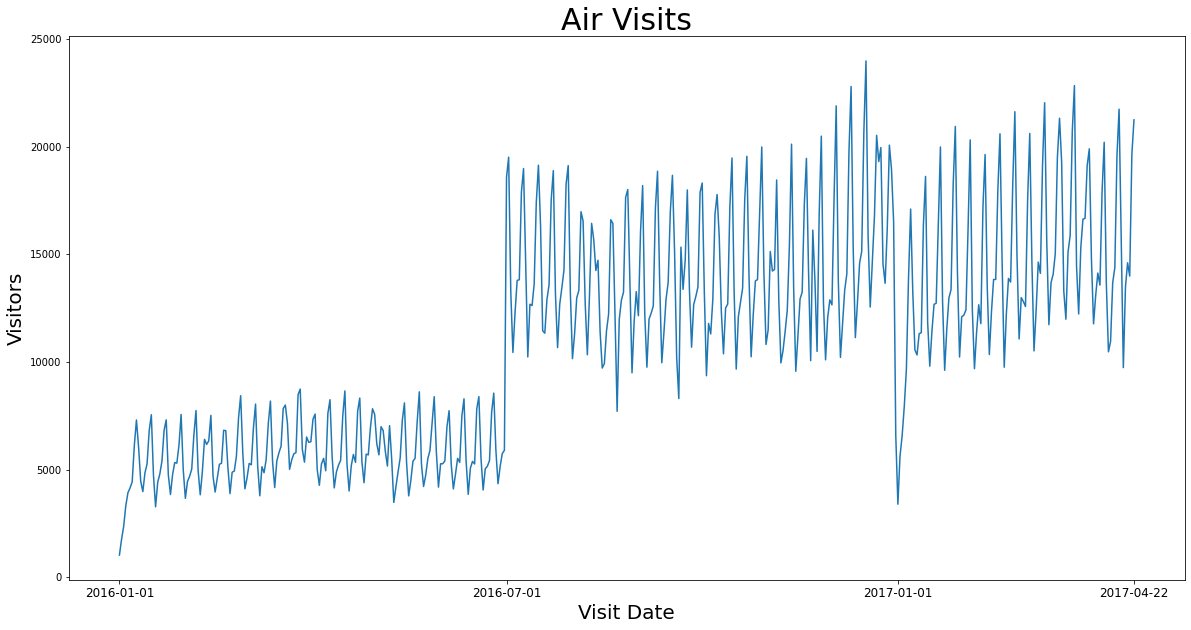

In [ ]:
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1, 1, 1)
tick  = ax.set_xticks([0, 182, 366, 477])
labels = ax.set_xticklabels(['2016-01-01', '2016-07-01','2017-01-01', '2017-04-22'], fontsize='large')
air_visit.groupby(['visit_date'])['visitors'].sum().plot()
plt.xlabel('Visit Date', fontsize = 20)
plt.ylabel('Visitors', fontsize = 20)
plt.title('Air Visits', fontsize = 30)

요일별 방문자 정보

Text(0, 0.5, 'Visitors')

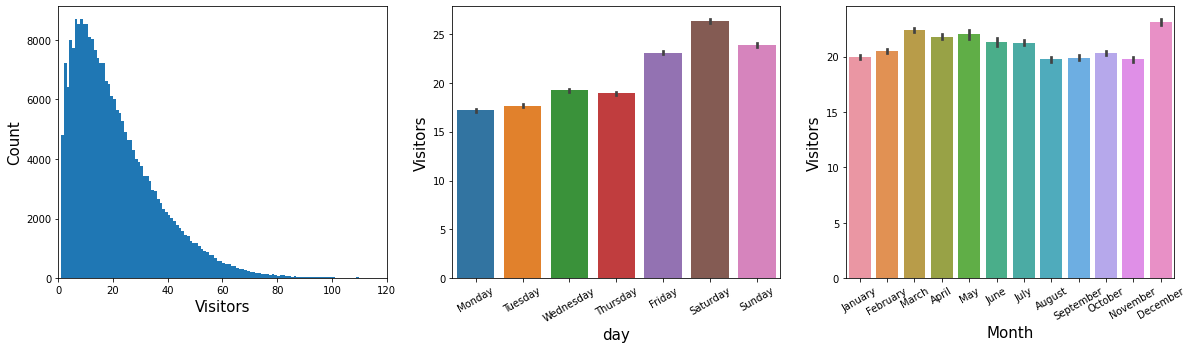

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.hist(air_visit['visitors'], bins = range(1, 200, 1))
plt.xlim([0, 120])
plt.xlabel('Visitors',fontsize = 15)
plt.ylabel('Count',fontsize = 15)

plt.subplot(1, 3, 2)
sns.barplot(data = air_visit, 
            x = 'day', y = 'visitors', 
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=30)
plt.xlabel('day',fontsize = 15)
plt.ylabel('Visitors',fontsize = 15)

plt.subplot(1, 3, 3)
sns.barplot(data = air_visit, 
            x = 'month', y = 'visitors')
plt.xticks(rotation=30)
plt.xlabel('Month',fontsize = 15)
plt.ylabel('Visitors',fontsize = 15)

air_reserve 데이터 확인

There were much fewer reservations made in 2016 through the air system even none at all for a long stretch of time.

The volume only increased during the end of 2016 and the visior numbers stayed strong in 2017.

Here, the time between making a reservation and visiting the restaurant follow a 24-hour pattern.

Very long time gaps between reservation and visit are not uncommon. (the restaurants are either fancy places, or there numbers are a result of a data imput error and got mixed up)

In [ ]:
air_reserve 정보 확인

In [ ]:
air_reserve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   air_store_id      92378 non-null  object
 1   visit_datetime    92378 non-null  object
 2   reserve_datetime  92378 non-null  object
 3   reserve_visitors  92378 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [ ]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [ ]:
air_reserve['visit_date'] = air_reserve['visit_datetime'].apply(lambda x : str(x[:10]))
air_reserve['visit_date'] = pd.to_datetime(air_reserve['visit_date'])
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01


Text(0.5, 1.0, 'Air Reservation')

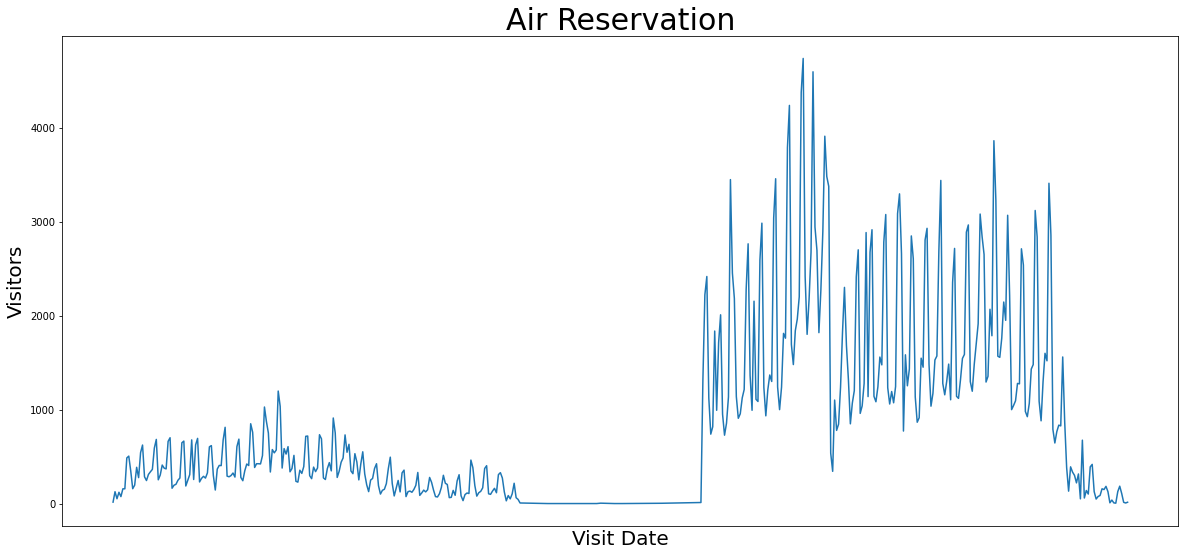

In [ ]:
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1, 1, 1)
tick  = ax.set_xticks([0, 182, 366, 477])
labels = ax.set_xticklabels(['2016-01-01', '2016-07-01','2017-01-01', '2017-04-22'], fontsize='large')
air_reserve.groupby(['visit_date'])['reserve_visitors'].sum().plot()
plt.xlabel('Visit Date', fontsize = 20)
plt.ylabel('Visitors', fontsize = 20)
plt.title('Air Reservation', fontsize = 30)

In [ ]:
# air_visit['month'] = pd.to_datetime(air_visit['visit_date'])

air_reserve['visit_hour'] = pd.to_datetime(air_reserve['visit_datetime']).dt.hour
air_reserve['visit_hour'] = air_reserve['visit_datetime'].dt.hour

air_reserve.head()



# air_reserve['reserve_datetime_diff'] = pd.to_datetime(air_visit['visit_datetime'])- pd.to_datetime(air_visit['reserve_datetime'])

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_hour
0,air_877f79706adbfb06,19,2016-01-01 16:00:00,1,0
1,air_db4b38ebe7a7ceff,19,2016-01-01 19:00:00,3,0
2,air_db4b38ebe7a7ceff,19,2016-01-01 19:00:00,6,0
3,air_877f79706adbfb06,20,2016-01-01 16:00:00,2,0
4,air_db80363d35f10926,20,2016-01-01 01:00:00,5,0


### Holidays

휴일에 대해 간단히 살펴보겠습니다. 2017년의 예측 기간과 2016년의 해당 시간 동안 총 개수와 분포도를 표시합니다.

* 2017년과 마찬가지로 2016년 4월말~5월도 같은 날 휴무였습니다.

* 전체 데이터에는 약 7%의 휴일이 있습니다.

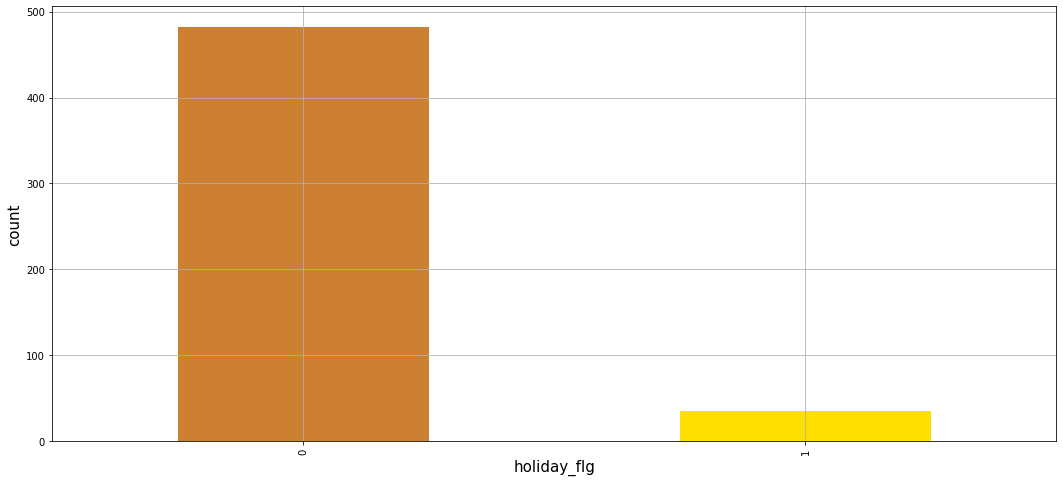

In [103]:
# 5.6 Holidays
f,ax = plt.subplots(1,1,figsize=(18,8))
holidays['holiday_flg'].value_counts().plot.bar(color=['#CD7F32','#FFDF00'],ax=ax)
plt.xlabel('holiday_flg',fontsize = 15)
plt.ylabel('count', fontsize=15)
plt.grid()
plt.show()


* 2017년과 마찬가지로 2016년 4월말~5월도 같은 날 휴무였습니다.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


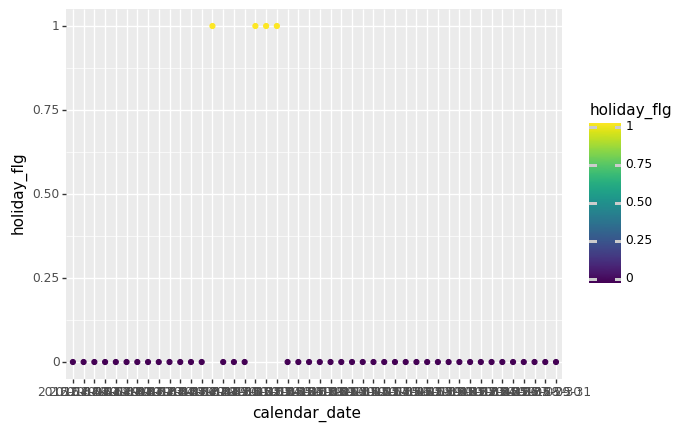

<ggplot: (8775464579153)>

In [ ]:
import plotnine as p9

# 2016/04/15 ~ 2016/06/01 년 휴일정보
p9.ggplot(data=holidays.query("calendar_date > '2016-04-15' and calendar_date < '2016-06-01'"), mapping=p9.aes(x='calendar_date',y='holiday_flg', color='holiday_flg')) + p9.geom_point()

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


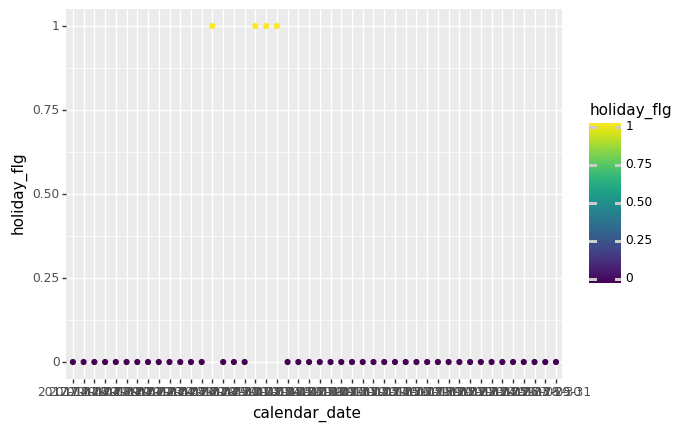

<ggplot: (8775464790153)>

In [ ]:
# 2017/04/15 ~ 2017/06/01 년 휴일정보
p9.ggplot(data=holidays.query("calendar_date > '2017-04-15' and calendar_date < '2017-06-01'"), mapping=p9.aes(x='calendar_date',y='holiday_flg', color='holiday_flg')) + p9.geom_point()

#### 5.2 The impact of holidays

휴일이 있는 날과 휴일 플래그가 없는 날의 통계를 비교하여 휴일이 방문자 수에 미치는 영향을 연구합니다.

In [106]:
air_visit_holidays = pd.merge(air_visit, holidays, how='left', left_on=['visit_date'], right_on=['calendar_date']) 
air_visit_holidays.query("holiday_flg=='1'")

,air_store_id,visit_date,visitors,day,month,calendar_date,day_of_week,holiday_flg
23,air_ba937bf13d40fb24,2016-02-11,3,Thursday,February,2016-02-11,Thursday,1
174,air_ba937bf13d40fb24,2016-08-11,2,Thursday,August,2016-08-11,Thursday,1
176,air_ba937bf13d40fb24,2016-08-13,21,Saturday,August,2016-08-13,Saturday,1
205,air_ba937bf13d40fb24,2016-09-22,21,Thursday,September,2016-09-22,Thursday,1
241,air_ba937bf13d40fb24,2016-11-03,12,Thursday,November,2016-11-03,Thursday,1
...,...,...,...,...,...,...,...,...
251985,air_24e8414b9b07decb,2016-11-23,8,Wednesday,November,2016-11-23,Wednesday,1
252010,air_24e8414b9b07decb,2016-12-23,8,Friday,December,2016-12-23,Friday,1
252016,air_24e8414b9b07decb,2016-12-29,2,Thursday,December,2016-12-29,Thursday,1
252017,air_24e8414b9b07decb,2016-12-30,7,Friday,December,2016-12-30,Friday,1


In [ ]:
air_visit_holidays.head()

,air_store_id,visit_date,visitors,day,month,calendar_date,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,January,2016-01-13,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,January,2016-01-14,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,January,2016-01-15,Friday,0
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,January,2016-01-16,Saturday,0
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,January,2016-01-18,Monday,0


/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


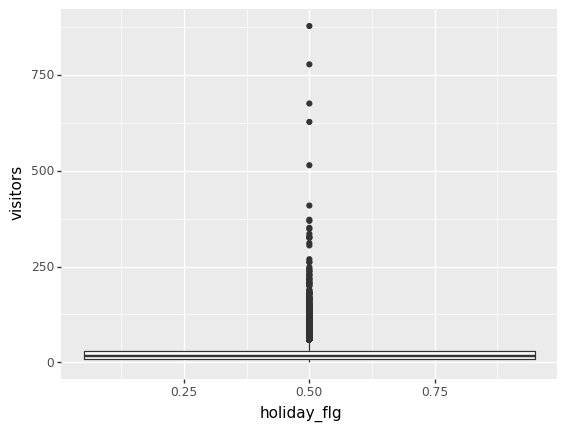

<ggplot: (8775448440721)>

In [104]:
p9.ggplot(data=air_visit_holidays, mapping=p9.aes(x='holiday_flg',y='visitors', color='holiday_flg')) + p9.geom_boxplot()

In [ ]:
air_visit_holidays.value_counts()

air_store_id          visit_date  visitors  day        month      calendar_date  day_of_week  holiday_flg
air_fff68b929994bfbd  2017-04-22  5         Saturday   April      2017-04-22     Saturday     0              1
air_5c817ef28f236bdf  2016-02-28  33        Sunday     February   2016-02-28     Sunday       0              1
                      2016-02-26  64        Friday     February   2016-02-26     Friday       0              1
                      2016-02-25  37        Thursday   February   2016-02-25     Thursday     0              1
                      2016-02-24  13        Wednesday  February   2016-02-24     Wednesday    0              1
                                                                                                            ..
air_a88ac559064dec08  2016-09-24  53        Saturday   September  2016-09-24     Saturday     0              1
                      2016-09-23  60        Friday     September  2016-09-23     Friday       0              1
      